# DNMT3A benchmarking with Training cohort data

#### DNMT3A methylation activity from Lue NZ, Garcia EM, Ngan KC, Lee C, Doench JG, Liau BB. Base editor scanning charts the DNMT3A activity landscape. Nat Chem Biol 2023;19:176–86.

### 1. Get and arrange data
### 2. Evaluation BoostDM vs Experimental assay
### 3.  F50 training and Japanese cohorts

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
from scipy.stats import fisher_exact
import copy
import gzip
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)
import matplotlib.pyplot as plt
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

## 1. Get and arrange data

In [3]:
# Data from Lue. et al Nat Chem Biol 2023
DNMT3A_score = pd.read_csv('../../../Paper_data/Experimental_data/DNMT3A/DNMT3A_metval.csv', sep=',')

In [5]:
#Select Missence and nonsense
DNMT3A_score = DNMT3A_score[DNMT3A_score['Mut_type'].isin(['Missense', 'Nonsense'])]
#Remove Not in 3A1
DNMT3A_score = DNMT3A_score[~DNMT3A_score['Mutation_list'].isin(['Not_in_3A1'])]
DNMT3A_score['Mutation_list'] = DNMT3A_score['Mutation_list'].str.replace(' ', '')
DNMT3A_score = DNMT3A_score.reset_index(drop=True)
# Remove sgRNA that include more than one mutations
DNMT3A_score = DNMT3A_score[~DNMT3A_score['Mutation_list'].str.contains(',')]
DNMT3A_score

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched
2,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched
3,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched
4,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched
5,DNMT3A2_428,CATCAAAGAGAGACAGCACC,Missense,MTase,D641N,1.455682,enriched
...,...,...,...,...,...,...,...
215,DNMT3A2_552,GGCATCAATCATCACAGGGT,Missense,MTase,D781N,-0.298170,unchanged
217,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged
218,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged
219,DNMT3A2_310,GGTAACATTGAGGCTCCCAC,Missense,ADD,V502I,-0.407768,unchanged


In [6]:
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'DNMT3A.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
gene_model

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,ID
0,DNMT3A,ENST00000264709,ENSG00000119772,2,25234282,A,V912V,0.0,0,0,0,0.028000,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,1.357464e-07,False,-0.058898,0.0,-0.189730,-0.192000,-2.699058,-0.000310,0.0,0.000144,0.000646,0.0,0.001585,0.226172,-0.285460,-0.044523,-3.631457,25234282A
1,DNMT3A,ENST00000264709,ENSG00000119772,2,25234282,G,V912V,0.0,0,0,0,0.028000,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,1.357464e-07,False,-0.058898,0.0,-0.189730,-0.192000,-2.699058,-0.000310,0.0,0.000144,0.000646,0.0,0.001585,0.226172,-0.285460,-0.044523,-3.631457,25234282G
2,DNMT3A,ENST00000264709,ENSG00000119772,2,25234282,T,V912V,0.0,0,0,0,0.028000,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,1.357464e-07,False,-0.058898,0.0,-0.189730,-0.192000,-2.699058,-0.000310,0.0,0.000144,0.000646,0.0,0.001585,0.226172,-0.285460,-0.044523,-3.631457,25234282T
3,DNMT3A,ENST00000264709,ENSG00000119772,2,25234283,C,V912G,0.0,0,0,0,3.158203,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.703106e-03,False,-0.113581,0.0,-0.435625,-0.403020,-1.569508,-0.000232,0.0,0.000216,0.001546,0.0,0.001933,-0.216448,-0.169009,-0.047392,0.182098,25234283C
4,DNMT3A,ENST00000264709,ENSG00000119772,2,25234283,G,V912A,0.0,0,0,0,3.158203,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.703106e-03,False,-0.113581,0.0,-0.435625,-0.403020,-1.569508,-0.000232,0.0,0.000216,0.001546,0.0,0.001933,-0.216448,-0.169009,-0.047392,0.182098,25234283G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194,DNMT3A,ENST00000264709,ENSG00000119772,2,25313980,C,P2R,0.0,0,0,0,4.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.487463e-02,False,-0.140410,0.0,-0.357837,-0.287609,-0.698487,-0.000135,0.0,0.000217,0.001849,0.0,0.002045,-0.288721,-0.168127,-0.049997,0.166221,25313980C
8195,DNMT3A,ENST00000264709,ENSG00000119772,2,25313980,T,P2H,0.0,0,0,0,4.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.487463e-02,False,-0.140410,0.0,-0.357837,-0.287609,-0.698487,-0.000135,0.0,0.000217,0.001849,0.0,0.002045,-0.288721,-0.168127,-0.049997,0.166221,25313980T
8196,DNMT3A,ENST00000264709,ENSG00000119772,2,25313981,A,P2S,0.0,0,0,0,4.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.487463e-02,False,-0.140410,0.0,-0.357837,-0.287609,-0.698487,-0.000135,0.0,0.000217,0.001849,0.0,0.002045,-0.288721,-0.168127,-0.049997,0.166221,25313981A
8197,DNMT3A,ENST00000264709,ENSG00000119772,2,25313981,C,P2A,0.0,0,0,0,4.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,1.487463e-02,False,-0.140410,0.0,-0.357837,-0.287609,-0.698487,-0.000135,0.0,0.000217,0.001849,0.0,0.002045,-0.288721,-0.168127,-0.049997,0.166221,25313981C


In [7]:
# Join the boostDM-score of all possible changes for the same missense mutation
DNMT3A_score['boostDM_score'] = DNMT3A_score['Mutation_list'].apply(lambda x: gene_model[gene_model['aachange']==x]['boostDM_score'].mean())
DNMT3A_score['boostDM_pred'] = DNMT3A_score['boostDM_score'].apply(lambda x: 1 if x >= 0.5 else 0)
DNMT3A_score

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,boostDM_score,boostDM_pred
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched,0.995337,1
2,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched,0.744854,1
3,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched,0.986471,1
4,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched,0.979201,1
5,DNMT3A2_428,CATCAAAGAGAGACAGCACC,Missense,MTase,D641N,1.455682,enriched,0.790142,1
...,...,...,...,...,...,...,...,...,...
215,DNMT3A2_552,GGCATCAATCATCACAGGGT,Missense,MTase,D781N,-0.298170,unchanged,0.162090,0
217,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged,0.001803,0
218,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged,0.362861,0
219,DNMT3A2_310,GGTAACATTGAGGCTCCCAC,Missense,ADD,V502I,-0.407768,unchanged,0.001783,0


In [8]:
DNMT3A_score = DNMT3A_score[DNMT3A_score['boostDM_score'].notna()]
DNMT3A_score

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,boostDM_score,boostDM_pred
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched,0.995337,1
2,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched,0.744854,1
3,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched,0.986471,1
4,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched,0.979201,1
5,DNMT3A2_428,CATCAAAGAGAGACAGCACC,Missense,MTase,D641N,1.455682,enriched,0.790142,1
...,...,...,...,...,...,...,...,...,...
212,DNMT3A2_417,GGGACAGGTGGGTAAACCTT,Missense,Inter2,V626I,-0.257446,unchanged,0.006466,0
215,DNMT3A2_552,GGCATCAATCATCACAGGGT,Missense,MTase,D781N,-0.298170,unchanged,0.162090,0
217,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged,0.001803,0
218,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged,0.362861,0


In [9]:
DNMT3A_score['boostDM_pred'].value_counts()

0    90
1    66
Name: boostDM_pred, dtype: int64

In [10]:
DNMT3A_score['Hit_status'].value_counts()

unchanged    114
enriched      42
Name: Hit_status, dtype: int64

In [11]:
len(set(DNMT3A_score['Mutation_list']))

127

## 2. Evaluation BoostDM vs Experimental assay

#### 2.A precision-recall curve

In [12]:
### Open file crossvalidation
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/DNMT3A_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

### Calculate boostDM prediction 0/1
gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

### Merge with boostDM prediction output to have the annotation of protein position
# Get saturation mutagenesis prediction
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'DNMT3A.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
# Merge
gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                              gene_crossval,
                              on=['chr', 'pos', 'alt'], how='right')
# Eliminate intronic/splicing rows
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

print(len(gene_crossval_info))

# Create dataframe for the predictions
gene_crossval_harv = gene_crossval_info
gene_crossval_harv['row'] = gene_crossval_harv.index   
gene_crossval_harv['ID'] = gene_crossval_harv['pos'].astype(str)+gene_crossval_harv['alt']

gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['ID'].isin(gene_model['ID'])]
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['aachange'].isin(DNMT3A_score['Mutation_list'])]
gene_crossval_harv['DNMT3A_met'] = gene_crossval_harv['aachange'].apply(lambda x:DNMT3A_score[DNMT3A_score['Mutation_list']==x]['sgRNA_score_d9_citrine_positive'].mean())
gene_crossval_harv

37468


,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,DNMT3A_met
1,DNMT3A,2,25240714,A,P700L,0.0000,0,1,1,9.945312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1,0.872798,0,1,1,25240714A,0.492397
7,DNMT3A,2,25247685,A,P307L,0.0000,0,1,1,9.890625,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1,0.845925,0,1,7,25247685A,-0.059215
52,DNMT3A,2,25240654,T,R720H,766.3811,1,0,1,7.859375,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.594194,0,1,52,25240654T,0.177470
71,DNMT3A,2,25244263,T,W581*,0.0000,0,1,0,7.847656,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,C,1,0.855582,0,1,71,25244263T,0.054314
82,DNMT3A,2,25247595,A,S337L,0.0000,0,1,1,9.890625,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1,0.845925,0,1,82,25247595A,1.094554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37381,DNMT3A,2,25245279,T,V510I,0.0000,0,0,0,0.244995,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0,0.031100,49,0,37381,25245279T,0.066227
37390,DNMT3A,2,25246671,T,A410T,0.0000,0,0,0,7.777344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.599759,49,1,37390,25246671T,-0.000862
37408,DNMT3A,2,25248047,A,P282L,0.0000,0,0,0,5.605469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0,0.127276,49,0,37408,25248047A,0.035576
37423,DNMT3A,2,25241669,A,R659C,0.0000,0,1,1,4.039062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0,0.702844,49,1,37423,25241669A,0.115525


In [14]:
gene_crossval_harv_equal = pd.DataFrame(columns=gene_crossval_harv.columns.tolist())

for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    gene_crossval_harv_equal = pd.concat([gene_crossval_harv_equal, gene_crossval_harv_equal_i])
gene_crossval_harv_equal.reset_index(drop=True, inplace=True)
gene_crossval_harv_equal['driver'] = gene_crossval_harv_equal['driver'].astype(float)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,DNMT3A_met
0,DNMT3A,2,25240358,T,E756K,0.0000,0,0,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.518337,0,1,274,25240358T,1.414057
1,DNMT3A,2,25244628,A,Q527*,0.0000,0,0,0,5.832031,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,G,1.0,0.737666,0,1,473,25244628A,1.601537
2,DNMT3A,2,25240714,A,P700L,0.0000,0,1,1,9.945312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.872798,0,1,1,25240714A,0.492397
3,DNMT3A,2,25240415,A,L737F,766.3811,1,1,1,5.910156,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.931119,0,1,512,25240415A,1.598453
4,DNMT3A,2,25234289,A,A910V,0.0000,0,0,0,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.632019,0,1,317,25234289A,0.392344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,DNMT3A,2,25247670,A,S312F,0.0000,0,1,1,9.804688,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.843368,49,1,37329,25247670A,0.676448
1056,DNMT3A,2,25245279,T,V510I,0.0000,0,0,0,0.244995,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.031100,49,0,37381,25245279T,0.066227
1057,DNMT3A,2,25248047,A,P282L,0.0000,0,0,0,5.605469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.127276,49,0,37408,25248047A,0.035576
1058,DNMT3A,2,25241669,A,R659C,0.0000,0,1,1,4.039062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.702844,49,1,37423,25241669A,0.115525


In [15]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}


# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['driver'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

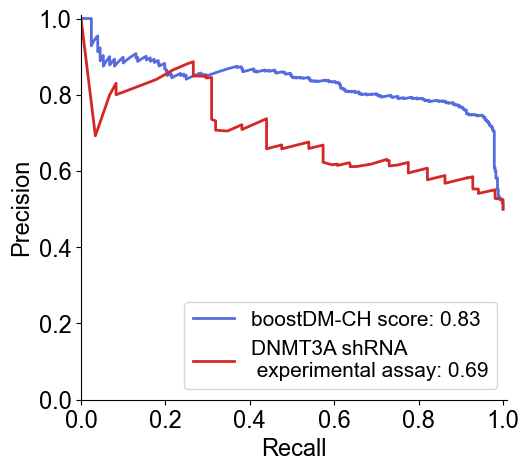

In [16]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(gene_crossval_harv_equal, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(gene_crossval_harv_equal, 'DNMT3A_met', ax=ax, color='#d62728', lw=2, alpha=1)
gene_crossval_harv_equal['prob_DNMT3A_met'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'DNMT3A shRNA\n experimental assay: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [17]:
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,DNMT3A_met,prob_DNMT3A_met
0,DNMT3A,2,25240358,T,E756K,0.0000,0,0,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.518337,0,1,274,25240358T,1.414057,0.843835
1,DNMT3A,2,25244628,A,Q527*,0.0000,0,0,0,5.832031,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,G,1.0,0.737666,0,1,473,25244628A,1.601537,0.878898
2,DNMT3A,2,25240714,A,P700L,0.0000,0,1,1,9.945312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.872798,0,1,1,25240714A,0.492397,0.558941
3,DNMT3A,2,25240415,A,L737F,766.3811,1,1,1,5.910156,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.931119,0,1,512,25240415A,1.598453,0.878381
4,DNMT3A,2,25234289,A,A910V,0.0000,0,0,0,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.632019,0,1,317,25234289A,0.392344,0.519849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,DNMT3A,2,25247670,A,S312F,0.0000,0,1,1,9.804688,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.843368,49,1,37329,25247670A,0.676448,0.628657
1056,DNMT3A,2,25245279,T,V510I,0.0000,0,0,0,0.244995,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.031100,49,0,37381,25245279T,0.066227,0.393245
1057,DNMT3A,2,25248047,A,P282L,0.0000,0,0,0,5.605469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.127276,49,0,37408,25248047A,0.035576,0.381799
1058,DNMT3A,2,25241669,A,R659C,0.0000,0,1,1,4.039062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.702844,49,1,37423,25241669A,0.115525,0.411898


In [18]:
gene_crossval_harv_equal['cat_DNMT3A_met'] = gene_crossval_harv_equal['prob_DNMT3A_met'].apply(lambda x:1 if x >=0.5 else 0)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,DNMT3A_met,prob_DNMT3A_met,cat_DNMT3A_met
0,DNMT3A,2,25240358,T,E756K,0.0000,0,0,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.518337,0,1,274,25240358T,1.414057,0.843835,1
1,DNMT3A,2,25244628,A,Q527*,0.0000,0,0,0,5.832031,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,G,1.0,0.737666,0,1,473,25244628A,1.601537,0.878898,1
2,DNMT3A,2,25240714,A,P700L,0.0000,0,1,1,9.945312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.872798,0,1,1,25240714A,0.492397,0.558941,1
3,DNMT3A,2,25240415,A,L737F,766.3811,1,1,1,5.910156,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.931119,0,1,512,25240415A,1.598453,0.878381,1
4,DNMT3A,2,25234289,A,A910V,0.0000,0,0,0,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.632019,0,1,317,25234289A,0.392344,0.519849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,DNMT3A,2,25247670,A,S312F,0.0000,0,1,1,9.804688,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.843368,49,1,37329,25247670A,0.676448,0.628657,1
1056,DNMT3A,2,25245279,T,V510I,0.0000,0,0,0,0.244995,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.031100,49,0,37381,25245279T,0.066227,0.393245,0
1057,DNMT3A,2,25248047,A,P282L,0.0000,0,0,0,5.605469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.127276,49,0,37408,25248047A,0.035576,0.381799,0
1058,DNMT3A,2,25241669,A,R659C,0.0000,0,1,1,4.039062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.702844,49,1,37423,25241669A,0.115525,0.411898,0


In [19]:
### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [20]:
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/DNMT3A_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)
gene_crossval

,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,chr,pos,ref,alt,driver,boostDM_score,iteration
0,0.0000,0,0,0,9.031250,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2,25248147,G,A,1,0.841080,0
1,0.0000,0,1,1,9.945312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25240714,G,A,1,0.872798,0
2,3630.5363,1,1,0,7.902344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25234373,C,T,1,0.968663,0
3,766.3811,1,1,1,9.328125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25240414,A,C,1,0.796573,0
4,0.0000,0,0,0,4.968750,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25248057,C,A,0,0.249506,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40433,0.0000,0,0,0,2.824219,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25274973,G,A,0,0.077803,49
40434,0.0000,0,0,0,4.003906,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25244216,C,A,1,0.075876,49
40435,0.0000,0,1,0,6.132812,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25244330,C,T,1,0.768253,49
40436,0.0000,0,0,0,0.608887,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2,25282549,C,A,1,0.038481,49


In [21]:
### Define function to calculate specific statistic

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['driver']==1) & (data[method]==1)])
    tn = len(data[(data['driver']==0) & (data[method]==0)])
    fp = len(data[(data['driver']==0) & (data[method]==1)])
    fn = len(data[(data['driver']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

#### F50 score

In [29]:

### Open file crossvalidation
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/DNMT3A_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

### Calculate boostDM prediction 0/1
gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

### Merge with boostDM prediction output to have the annotation of protein position
# Get saturation mutagenesis prediction
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'DNMT3A.CH.prediction.tsv.gz', sep='\t')
# Merge
gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                              gene_crossval,
                              on=['chr', 'pos', 'alt'], how='right')
# Eliminate intronic/splicing rows
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].isin(DNMT3A_score['Mutation_list'].tolist())]
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

print(len(gene_crossval_info))

# Create dataframe for the predictions
gene_crossval_harv = gene_crossval_info
gene_crossval_harv['row'] = gene_crossval_harv.index        

### Get predictions from Harvard models (Niroula/Bick) and add to dataframe
DNMT3A_positive = DNMT3A_score[DNMT3A_score['Hit_status'] == 'enriched']['Mutation_list'].tolist()
gene_crossval_harv['methylation'] = gene_crossval_harv['aachange'].apply(lambda x: 1 if x in DNMT3A_positive else 0)

#make same random
driv1 = gene_crossval_harv[gene_crossval_harv['driver']==1]
print(len(driv1))
driv0 = gene_crossval_harv[gene_crossval_harv['driver']==0]
print(len(driv0))
if len(driv1) > len(driv0):
    driv1 = driv1.sample(n=len(driv0), random_state=42)
elif len(driv1) < len(driv0):
    driv0 = driv0.sample(n=len(driv1), random_state=42)
print(len(driv1))
print(len(driv0))
gene_crossval_harv_equal = pd.concat([driv1, driv0])

### Calculate statistic
results_stat = []
for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:   
    statistics = [statistic]
    statistics.append(quality_statistic(gene_crossval_harv_equal, 'boostDM_predic', statistic=statistic))
    statistics.append(quality_statistic(gene_crossval_harv_equal, 'methylation', statistic=statistic))
    results_stat.append(statistics)

results_dataframe_12 = pd.DataFrame(results_stat)
results_dataframe_12.columns = ['Statistic', 'BoostDM', 'experimental']
results_dataframe_12

1643
1113
530
530
530


,Statistic,BoostDM,experimental
0,Fscore50,0.766458,0.602837
1,F1,0.818410,0.534231
2,Accuracy,0.795283,0.608491
3,Precision,0.735338,0.659280
4,Recall,0.922642,0.449057
5,NPV,0.896203,0.582260


In [30]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'experimental': pd.DataFrame(eval_experimental).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q1': pd.DataFrame(eval_experimental).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q3': pd.DataFrame(eval_experimental).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.784056,0.603114,0.737058,0.833333,0.522204,0.675676
1,F1,0.839415,0.531559,0.803125,0.886667,0.456294,0.597059
2,Accuracy,0.814209,0.608234,0.773990,0.872159,0.545455,0.666667
3,Precision,0.751731,0.669697,0.694231,0.800000,0.559524,0.750000
4,Recall,0.956846,0.452990,0.918269,1.000000,0.384615,0.500000
5,NPV,0.942557,0.585994,0.891667,1.000000,0.534615,0.631119


In [31]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)

plot_data

,Statistic,BoostDM,experimental
0,$F_{50}$,0.784056,0.603114
1,Precision,0.751731,0.669697
2,Recall,0.956846,0.452990


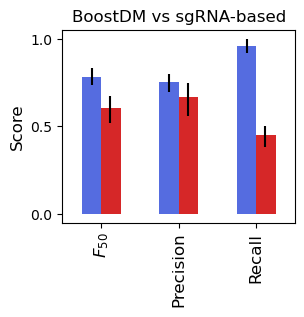

In [32]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.BoostDM-row.BoostDM_Q1], [row.BoostDM_Q3-row.BoostDM]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.experimental-row.experimental_Q1], [row.experimental_Q3-row.experimental]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.title('BoostDM vs sgRNA-based', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

# 3.  F50 training and Japanese cohorts

In [33]:
cross_validation = results_dataframe_12.loc[0:0,:]
cross_validation['Statistic'] = 'TCGA + HMF + MSKCC'
cross_validation = cross_validation.rename(columns={'sgRNA': 'experimental'})
cross_validation

/tmp/jobs/jramis/9874679/ipykernel_13950/3152205204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validation['Statistic'] = 'TCGA + HMF + MSKCC'


,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,TCGA + HMF + MSKCC,0.784056,0.603114,0.737058,0.833333,0.522204,0.675676


In [34]:
### Open Gao et al NatCom 2021 (MSKCC) - Open Bolton et al NatGen 2020 (MSKCC)

Japanese = pd.read_csv("Japanese_crossvalidation_DNMT3A.csv", sep='\t')
Japanese = Japanese.loc[0:0,:]
Japanese['Statistic'] = 'Japanese Biobank'
Japanese

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,Japanese Biobank,0.73213,0.660865,0.684524,0.756579,0.625,0.693269


In [35]:
cross_validation_all = pd.concat([cross_validation, Japanese])
cross_validation_all

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,TCGA + HMF + MSKCC,0.784056,0.603114,0.737058,0.833333,0.522204,0.675676
0,Japanese Biobank,0.732130,0.660865,0.684524,0.756579,0.625000,0.693269


In [36]:
cross_validation_all = cross_validation_all.reset_index(drop=True)

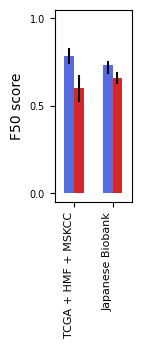

In [37]:
mpl.style.use('default')
cross_validation_all.iloc[:,:3].plot.bar(x='Statistic', figsize=(1,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in cross_validation_all.iloc[::-1].iterrows():
    ci = [[abs(row.BoostDM-row.BoostDM_Q1)], [abs(row.BoostDM_Q3-row.BoostDM)]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in cross_validation_all.iloc[::-1].iterrows():
    ci = [[row.experimental-row.experimental_Q1], [row.experimental_Q3-row.experimental]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.ylabel('F50 score', size=10)
plt.xticks(size=8, rotation=90, horizontalalignment='right', verticalalignment='top')
plt.yticks(size=7)
plt.xlabel('')
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
plt.show()